In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.linalg as LA
import numpy as np

from model import *
from Simulator import *

## visualizing

In [2]:
models=[
    {'name': SSP, 'kwargs': {'incongruency': True}}, 
    # {'name': SSP, 'kwargs': {'incongruency': False}},
]
dataset = SSP_DDM_Dataset(n_obs=10, length=1000, models=models)
dataloader = DataLoader(dataset, batch_size=64)
for i ,(m,p,x) in enumerate(dataloader):
    x1 = x
    break
models=[
    # {'name': SSP, 'kwargs': {'incongruency': True}}, 
    {'name': SSP, 'kwargs': {'incongruency': False}},
]
dataset = SSP_DDM_Dataset(n_obs=10, length=1000, models=models)
dataloader = DataLoader(dataset, batch_size=64)
for i ,(m,p,x) in enumerate(dataloader):
    x2 = x
    break

In [3]:
x1.mean(), x2.mean()

(tensor(0.5725), tensor(1.1557))

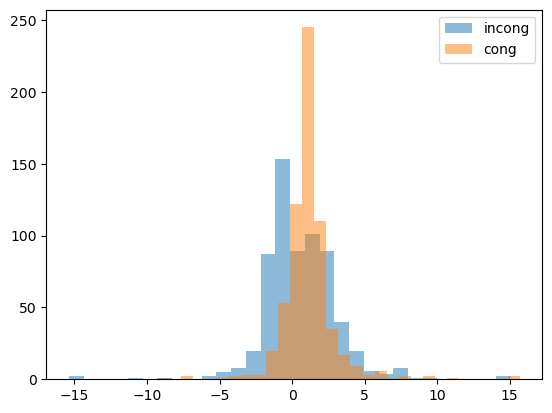

In [4]:
fig, axes = plt.subplots(1,1)
axes.hist(x1.reshape(-1), bins=30, alpha=0.5, label='incong')
axes.hist(x2.reshape(-1), bins=30, alpha=0.5, label='cong')
axes.legend()
plt.show()

# training

In [11]:
models=[
    {'name': SSP, 'kwargs': {'incongruency': True}}, 
    {'name': SSP, 'kwargs': {'incongruency': False}},
]
# f_n_obs = np.random.choice([10 * (i+1) for i in range(10)])
dataset = SSP_DDM_Dataset(n_obs=100, length=1000, models=models)
dataloader = DataLoader(dataset, batch_size=1)

In [12]:
equiv_dim, inv_dim, evid_dim = 64, 64, 128
summary_net = InvariantNetwork(1, equiv_dim, inv_dim)
evidential_net = EvidentialNetwork(inv_dim + 1, evid_dim, n_models=2)

In [13]:
(sum([p.numel() for p in summary_net.parameters()]),
sum([p.numel() for p in evidential_net.parameters()]))

(66688, 41730)

In [47]:
params = torch.load('ckpt_ssp.pth')
summary_net.load_state_dict(params['summary_net'])
evidential_net.load_state_dict(params['evidential_net'])

<All keys matched successfully>

In [14]:
device = 'cuda'
summary_net = summary_net.to(device)
evidential_net = evidential_net.to(device)

In [16]:
epoch = 5
lr = 1e-4
from torch.optim import Adam
optimizer = Adam([
    {'params': summary_net.parameters()},
    {'params': evidential_net.parameters()}
], lr=lr)
lamb = 0.1

In [17]:
rec_loss = []
rec_acc = []
for i_epoch in range(epoch):
    for i ,(m,p,x) in enumerate(dataloader):
        m = m.to(device)
        x = x.to(device)
        
        optimizer.zero_grad()

        alpha = evidential_net(summary_net(x))

        l1 = loss_cls(alpha, m)
        l2 = loss_kl(alpha, m)
        l = l1 + lamb * l2

        l.backward()
        optimizer.step()

        rec_loss.append(l.item())
        rec_acc.append(((alpha.argmax(dim=-1)==m.argmax(dim=-1)).float().sum() / alpha.shape[0]).item())

        # if i % 100 == 99:
        #     print(l.item(), l1.item(), l2.item())

    if 1:
        print(f"epoch {i_epoch}:, {sum(rec_loss) / len(rec_loss): 6.4f}, {sum(rec_acc) / len(rec_acc): 6.4f}")
        rec_loss = []
        rec_acc = []
        torch.save({
            'summary_net': summary_net.state_dict(),
            'evidential_net': evidential_net.state_dict()
            }, 'ckpt_ssp.pth')


epoch 0:,  0.6583,  0.6030


KeyboardInterrupt: 